### Задание

In [1]:
import torch
import torch.nn as nn

1. Загрузите выборку passengers.csv. Примените `MinMaxScaler` из модуля `sklearn.preprocessing` в временному ряду `num_passengers`.

In [2]:
import pandas as pd
import numpy as np

In [3]:
pas = pd.read_csv('data/passengers.csv', dtype={'num_passangers': np.float64})

In [4]:
pas.head(3)

,date,num_passengers
0,1949-1-1,112
1,1949-2-1,118
2,1949-3-1,132


In [5]:
x, y = pas.values[:, :-1], pas.values[:, -1]

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
mms = MinMaxScaler()

In [10]:
yr = mms.fit_transform(y.reshape(-1, 1))

2. Напишите функцию, которая принимает на вход временной ряд и ширину окна `k`, а возвращает `X`, `y` в формате `torch.Tensor`. Каждая строка объекта `X` должна содержать значения временного ряда $y_{t-k}, \ldots, y_{t-1}$, а на соответствующей позиции объекта `y` будет содержаться ответ $y_t$.

In [60]:
def make_tensor(y, k):
    newX = np.array([]).reshape(0, k)
    newY = y[k:]
    for i in range(y.shape[0]-k):
        newX = np.vstack([newX, y[i:i+k,:].reshape(1, -1)])
    return torch.FloatTensor(newX), torch.FloatTensor(newY)

3. Воспользуйтесь готовой функцией с шириной окна `k=12`. Измените размерность `X` на (размер выборки, количество каналов `1`, ширина окна `k`).

In [61]:
tX, ty = make_tensor(yr, 12)

In [62]:
tX.type()

'torch.FloatTensor'

In [63]:
canalsX = tX.reshape(tX.shape[0], 1, 12)

4. Разделите выборку на обучение и контроль. Для контроля оставьте 36 последних значений.

In [72]:
X_train, X_test = canalsX[:-36], canalsX[-36:]
y_train, y_test = ty[:-36], ty[-36:]

5. Напишите класс для сверточной нейронной сети `CNN`. Нейронная сеть должна иметь следующую архитектуру:

- первый слой &ndash; сверточный (`torch.nn.Conv1D`): число каналов на вход &ndash; 1, на выход &ndash; 64, размер ядра свертки &ndash; 8, `stride=1`, функция активации &ndash; ReLU (`torch.nn.ReLU()`);
- второй слой &ndash; слой субдискретизации (`torch.nn.MaxPool1d`) с шириной окна 5;
- после применения сверточного слоя и слоя субдискретизации необходимо воспользоваться функцией `torch.flatten(..., 1)`, чтобы преобразовать полученный результат в вектор. Количество элементов вектора окажется равным 64 (подумайте, почему);
- полученный вектор передается на вход полносвязному слою `torch.nn.Linear` с 50 нейронами скрытого слоя, функция активации также ReLU;
- результат передается на выход сети (еще один `torch.nn.Linear` с 1 нейроном на выходном слое).

In [93]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=8, stride=1)
        self.pool_layer1 = nn.MaxPool1d(kernel_size=5)
        
        self.linear_layer1 = nn.Linear(in_features=64, out_features=50)
        self.linear_layer2 = nn.Linear(in_features=50, out_features=1)
        
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        output = self.relu(self.conv_layer1(inputs))
        output = self.pool_layer1(output)
        
        output = torch.flatten(output, 1)
        
        output = self.relu(self.linear_layer1(output))
        output = self.linear_layer2(output)
        
        return output

6. Для обучения сети задайте функцию активации `torch.nn.MSELoss()` и используйте метод `Adam` с шагом обучения `lr=0.001`. Обучите сверточную нейронную сеть на 1000 эпохах. Размер мини-батча &ndash; вся выборка. Во время обучения выводите величину функции потерь на обучающей выборке каждые 100 эпох.

In [99]:
model = CNN()

In [100]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [101]:
_ = torch.manual_seed(0)

epochs = 1000
for epoch in range(epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

7. Вызовите метод `.eval()` обученной модели, чтобы перейти к построению прогноза. Получите предсказания модели для тестовой выборки. Преобразуйте предсказания обратно к массиву numpy через метод `.data.numpy()`. С помощью метода `inverse_transform` у `MinMaxScaler` получите предсказания для исходного временного ряда.

In [102]:
_ = model.eval()

In [116]:
pred = mms.inverse_transform(model(X_test).detach().numpy())

8. Отобразите на графике исходный ряд и полученный прогноз.

In [128]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Результаты прогнозирования')

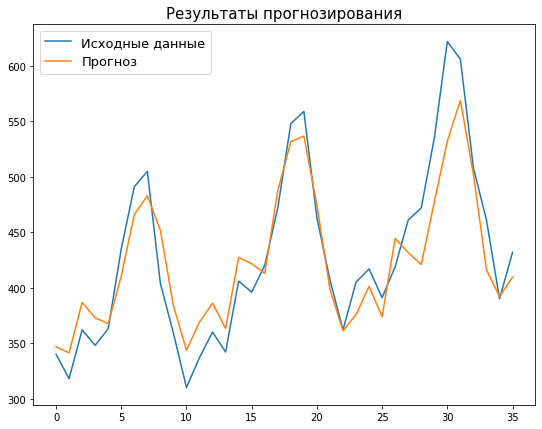

In [135]:
fig, ax = plt.subplots(figsize=(9,7))

x = range(yr[-36:].shape[0])

ax.plot(x, y[-36:], label='Исходные данные')
ax.plot(x, pred, label='Прогноз')
plt.legend(fontsize=13)
plt.title('Результаты прогнозирования', fontsize=15)